# 电影票房拟合（插值）和预测（数值积分）

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.interpolate as spi
from scipy.linalg import solve

In [3]:
# 票房数据单位 万/周
weekZL_x = np.arange(12)
weekZL_y = np.array([99681.0, 217126.0, 140241.0, 56448.0, 26080.0, 17194.0, 5564.0,
                    2289.0, 1197.0, 619.0, 1029.0, 210.0])
assert weekZL_x.size == weekZL_y.size, "the size of ZL data is wrong"
weekLL_x = np.arange(14)
weekLL_y = np.array([0,202074.0, 177540.0, 56644.0, 17872.0, 6617.0, 2514.0, 1100.0,
                    462.0, 289.0, 127.0, 150.0, 41.0, 47.0]) 
assert weekLL_x.size == weekLL_y.size, "the size of LL data is wrong"

### 选择插值方法，并编写插值函数（第一题写的插值方法就可以用感觉）

In [4]:
# # lar = spi.lagrange(weekZL_x,weekZL_y)
# # xx = np.linspace(0,12,1000)
# # plt.plot(xx,lar(xx))
# # # 龙格现象，不能用，多项式插值
# # 我决定用插值法和最小二乘法算出曲线函数，然后用最小二乘法进行数值积分
# def myl(x,y,k=1):
#     # k=1,y = a + bx,g=[1,x] 
#     if k == 1: 
#         g = np.ones([x.size,2])
#         for i in range(x.size):
#             g[i,1] = x[i]
#             # k=2 y=a+bx+cx*x
#     elif k == 2:
#         g = np.ones([x.size,3])
#         for i in range(x.size):
#             g[i,1]=x[i]
#             g[i,2]=np.square(x[i])
#             # k=3 y=a+bx+cx*x+dx*xxx
#     elif k == 3:
#         g = np.ones([x.size,4])
#         for i in range(x.size):
#             g[i,1]=x[i]
#             g[i,2]=np.square(x[i])
#             g[i,3]=pow(x[i],3)
#             # g*g'a=g'y
#     G = np.transpose(g)
#     y_solve = np.dot(G,y)
#     y_solve = np.transpose(y_solve)
#     A = np.dot(G,g)
#     para = solve(A,y_solve)
#     #     print(para)
#     return para

# def fucx(x,para,k):
#     if k == 1 :
#         ans = para[0]+para[1]*x
#     elif k == 2:
#         ans = para[0]+para[1]*x+para[2]*x*x
#     elif k == 3:
#         ans = para[0]+para[1]*x+para[2]*x*x+para[3]*x*x*x
#     return ans


In [5]:
# k = 2 
# para = myl(weekLL_x,weekLL_y,k)
# x_plot = np.linspace(0,13,10000)
# y_plot = np.array([fucx(t,para,k) for t in x_plot])

# # plt.axis('scaled')
# plt.scatter(weekLL_x,weekLL_y)
# plt.plot(x_plot,y_plot)

### 三次样条插值法
还有一些**和h，和size相关的**应该写成**超参数**，在后续修改的时候会方便得多

In [6]:
def Chasing(a,b,c,d,show=True):
# 初始化系数矩阵
# 仅支持上下宽为1的追赶法，后续可能需要修改一下这个方法。
    l = np.zeros(a.size)
    u = np.zeros(b.size)
    y = np.ones(d.size)
    M = np.zeros(y.size)
    u[0] = b[0]
    y[0] = d[0]
# 求出系数矩阵
    for i in range(l.size):
        l[i] = a[i]/u[i]
        u[i+1] = b[i+1]-l[i]*c[i]
# 求解Ly=d
    for i in range(1,y.size):
        y[i] = d[i]-y[i-1]*l[i-1]
# 求解UM=y
    M[M.size-1] = y[y.size-1]/u[y.size-1]
    for i in range(M.size-2,-1,-1):
        M[i] = (y[i]-c[i]*M[i+1])/u[i]
# 控制参数显示
    if show==True:
        ShowAns(l,u,c,M)
    return M

# 结果展示函数
def ShowAns(l,u,c,M):
    print('*****************l**********')
    print(l)
    print('*****************u**********')
    print(u)
    print('*****************c**********')
    print(c)
    print('*****************M**********')
    print(M)
    pass

### 针对与特定问题的三次样条插值设置


In [7]:
# 三次样条插值part
Dimension = weekLL_x.size -2 
h = 1 
Diag = 2*np.ones(Dimension)
ld = 0.5*np.ones(Dimension-1)
u3 = 0.5*np.ones(Dimension-1)
# 通过差商求出自然边界条件下的d的各项值
# 这一部分和上面那一部分讲道理可以改写成函数的。
d = np.zeros(Dimension)
for i in range(Dimension):
    d[i] = 3*(weekLL_y[i+2]-2*weekLL_y[i+1]+weekLL_y[i])
    pass
# print(d)

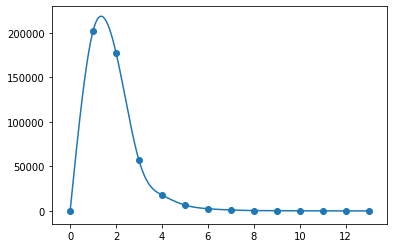

In [8]:
# 然后建立样条分段函数
# 并绘制图像
# 求出M
fake_M = Chasing(u3,Diag,ld,d,False)
M = np.zeros(fake_M.size+2)
M[1:M.size-1] = fake_M

# 建立三次样条插值函数（分段）
def MSpline3(data_x,data_y,M,h,x):
    assert x >= 0, "the x value is undefind(wrong)"
    index = x + 1
    index = int(index)
    if index>=13: index=13
    V1 = pow(data_x[index]-x,3)*M[index-1]/6 
    V2 = pow(x-data_x[index-1],3)*M[index]/6
    V3 = (data_y[index-1]-M[index-1]/6)*(data_x[index]-x)
    V4 = (data_y[index]-M[index]/6)*(x-data_x[index-1])
    return V1+V2+V3+V4

# 绘制三次样条插值后的图像
x_plot = np.linspace(0,13,1000)
y_plot = np.array([MSpline3(weekLL_x,weekLL_y,M,h,t) for t in x_plot])
LineLens = 0

plt.plot(x_plot,y_plot)
plt.scatter(weekLL_x,weekLL_y)

### 变上限积分求解超过50e的时间
** KEY METHOD**  
- 数值积分方法(折衷一下，用复化simpson求积公式)
- 变上限积分
- 最小二乘拟合的函数/三次样条插值的最后一段函数（趋于平缓，近似同化？）

In [9]:
# def my2ChIntegral(func,x_plot,threshold=500000,k=3):
#     Ans = 0
#     h = x_plot[1] - x_plot[0]
#     for i in range(x_plot.size-1):
#         Value1 = func(x_plot[i],para,k) + func(x_plot[i+1],para,k)
#         temp = (x_plot[i]+x_plot[i+1])/2
#         Value2 = func(temp,para,k)
#         Ans = Ans + (Value1 + 4*Value2)*h/6  
#     print(Ans)
# #     先算出目前的总和，然后用while控制变上限积分
#     index = x_plot.size - 1 
#     x_1 = x_plot[index]
#     x_2 = x_plot[index] + h
#     times = 0
#     while(Ans<threshold):
#         Value1 = func(x_1,para,k) + func(x_2,para,k)
#         temp = (x_1+x_2)/2
#         Value2 = func(temp,para,k)
#         Ans = Ans + (Value1 + 4*Value2)*h/6
#         x_1 = x_2
#         x_2 = x_2 + h
#         times = times+1
#         if times > 5000: 
#             return x_2
#         pass
#     return x_2

In [10]:
# # Ans=my2ChIntegral(fucx,x_plot)
# Ans = my2ChIntegral(MSpline3(weekLL_x,weekLL_y,M,h,))
# Ans

In [11]:
def my3ChIntegral(func,x_plot,threshold=500000):
    Ans = 0 
    h = x_plot[1]-x_plot[0]
    for i in range(x_plot.size-1):
        Value1 = func(weekLL_x,weekLL_y,M,h,x_plot[i]) + func(weekLL_x,weekLL_y,M,h,x_plot[i+1])
        temp = (x_plot[i]+x_plot[i+1])/2
        Value2 = func(weekLL_x,weekLL_y,M,h,temp)
        Ans = Ans + (Value1 + 4*Value2)*h/6  
#     print(Ans)
    index = x_plot.size -1 
    x_1 = x_plot[index]
    x_2 = x_plot[index] + h
    times = 0 
    while(Ans<threshold):
        Value1 = func(weekLL_x,weekLL_y,M,h,x_1) + func(weekLL_x,weekLL_y,M,h,x_2)
        temp = (x_1+x_2)/2
        Value2 = func(weekLL_x,weekLL_y,M,h,temp)
        Ans = Ans + (Value1 + 4*Value2)*h/6
        x_1 = x_2
        x_2 = x_2 + h
        times = times+1
        if times > 5000: 
#             print(x_2)
            break
    print(x_2)
    return x_2
Ans = my3ChIntegral(MSpline3,x_plot)

486651.6425037561
78.09109109109103
78.09109109109103
